In [27]:
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import *
from src.data_preprocessing import *

import numpy as np
from typing import List, Callable
from sklearn.linear_model import LinearRegression
from functools import partial


%reload_ext autoreload
%autoreload 2

%aimport src.utils
%aimport src.data_preprocessing 

df = pd.read_csv(conf.dataset_path, index_col='Date')
df = df.iloc[::-1]

### Dataset and it's statistics

In [28]:
df.head()

,Volume,Open,Close,High,Low
Date,,,,,
2021/08/27,2.045602e+05,0.493377,0.618263,0.619192,0.463996
2021/08/28,1.166856e+05,0.618263,0.602768,0.633747,0.531502
2021/08/29,1.105447e+05,0.602768,0.548015,0.610971,0.514528
2021/08/30,6.956799e+05,0.548015,0.879532,0.939249,0.545316
2021/08/31,1.317655e+06,0.879532,1.045401,1.148265,0.798556


In [29]:
df.describe()

,Volume,Open,Close,High,Low
count,8.040000e+02,804.000000,804.000000,804.000000,804.000000
mean,6.464789e+06,1.836827,1.839542,1.908602,1.771327
std,8.979842e+06,0.699373,0.698249,0.743568,0.671632
min,2.566223e+04,0.493377,0.548015,0.610971,0.383749
25%,9.224466e+05,1.346002,1.346727,1.373812,1.294619
50%,2.994136e+06,1.839500,1.839909,1.879509,1.793037
75%,7.582020e+06,2.266575,2.268144,2.322603,2.208749
max,6.165645e+07,4.427254,4.432000,5.315531,4.191664


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 804 entries, 2021/08/27 to 2023/11/08
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  804 non-null    float64
 1   Open    804 non-null    float64
 2   Close   804 non-null    float64
 3   High    804 non-null    float64
 4   Low     804 non-null    float64
dtypes: float64(5)
memory usage: 37.7+ KB


In [31]:
print(df.head().to_markdown())

| Date       |           Volume |     Open |    Close |     High |      Low |
|:-----------|-----------------:|---------:|---------:|---------:|---------:|
| 2021/08/27 | 204560           | 0.493377 | 0.618263 | 0.619192 | 0.463996 |
| 2021/08/28 | 116686           | 0.618263 | 0.602768 | 0.633747 | 0.531502 |
| 2021/08/29 | 110545           | 0.602768 | 0.548015 | 0.610971 | 0.514528 |
| 2021/08/30 | 695680           | 0.548015 | 0.879532 | 0.939249 | 0.545316 |
| 2021/08/31 |      1.31766e+06 | 0.879532 | 1.0454   | 1.14827  | 0.798556 |


### Data visualization

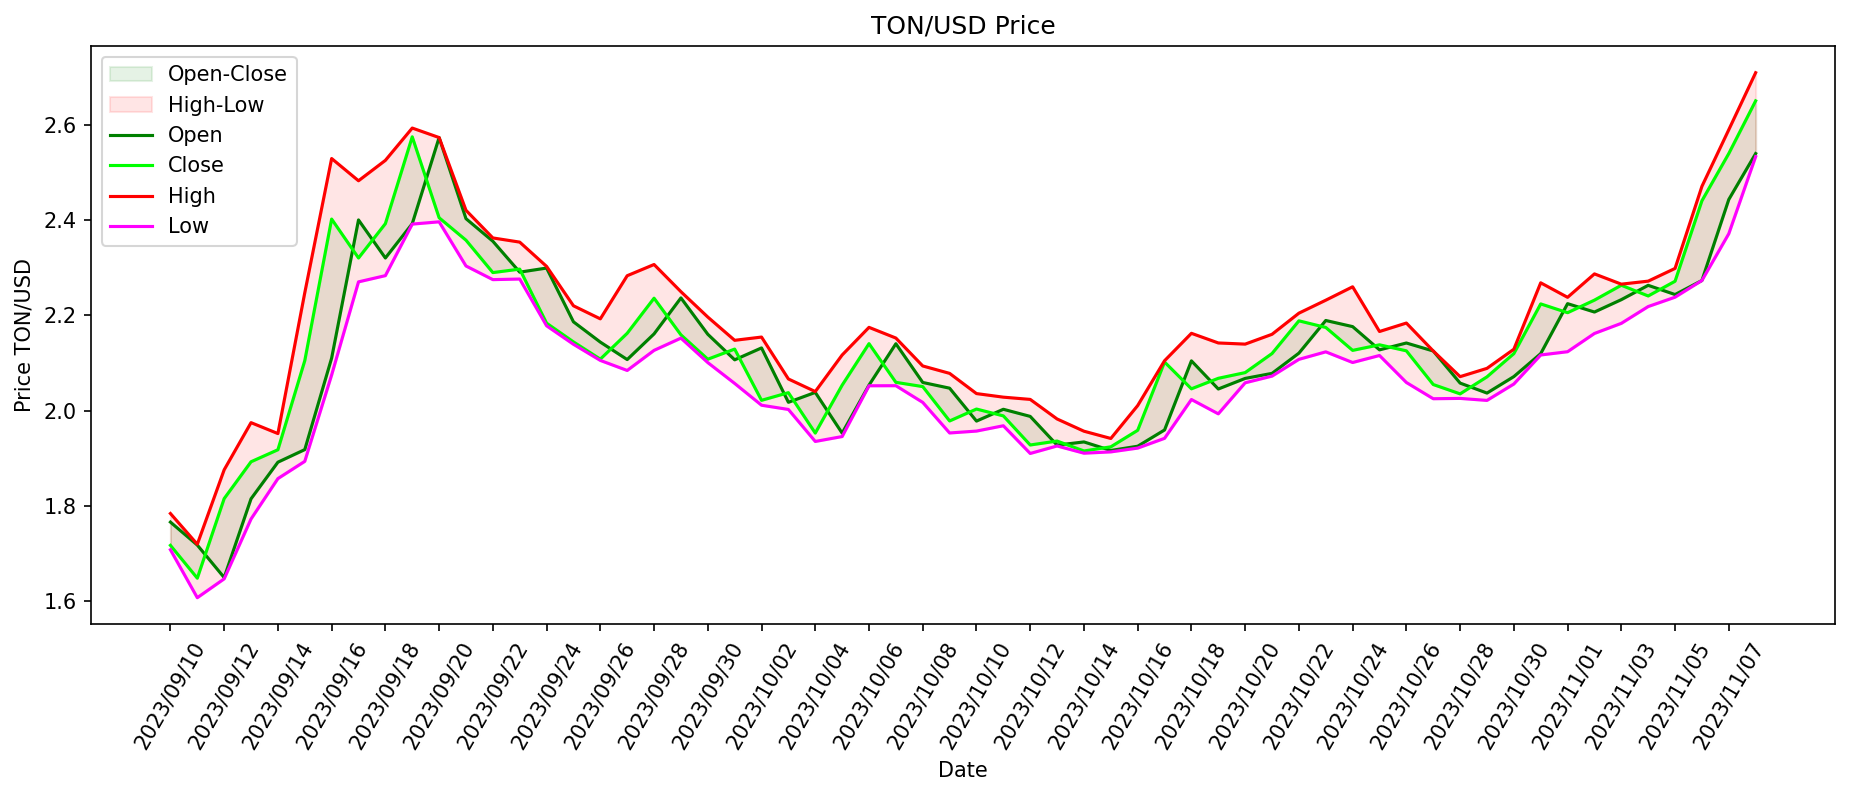

In [32]:
# show only last 2 months
# make text bigger for better readability
df_last_2_months = df.tail(60)

fig = plt.figure(figsize=(15, 5), dpi=150, facecolor='w', edgecolor='k')


plt.fill_between(df_last_2_months.index, df_last_2_months['Open'], df_last_2_months['Close'], color='green', alpha=0.10)
plt.fill_between(df_last_2_months.index, df_last_2_months['High'], df_last_2_months['Low'], color='red', alpha=0.10)
plt.plot(df_last_2_months.index, df_last_2_months['Open'], color='green')
plt.plot(df_last_2_months.index, df_last_2_months['Close'], color='lime')
plt.plot(df_last_2_months.index, df_last_2_months['High'], color='red')
plt.plot(df_last_2_months.index, df_last_2_months['Low'], color='magenta')

plt.legend(['Open-Close', 'High-Low', 'Open', 'Close', 'High', 'Low'])

plt.xticks(rotation=60)
plt.xticks(df_last_2_months.index[::2])
plt.xlabel('Date')
plt.ylabel('Price TON/USD')
plt.title('TON/USD Price')

plt.show()

We alredy know that Open and Close are the same, because of Open is the lag 1 of Close. 

Now we will create diff between Open and Close, High and Low, and plot their distributions.

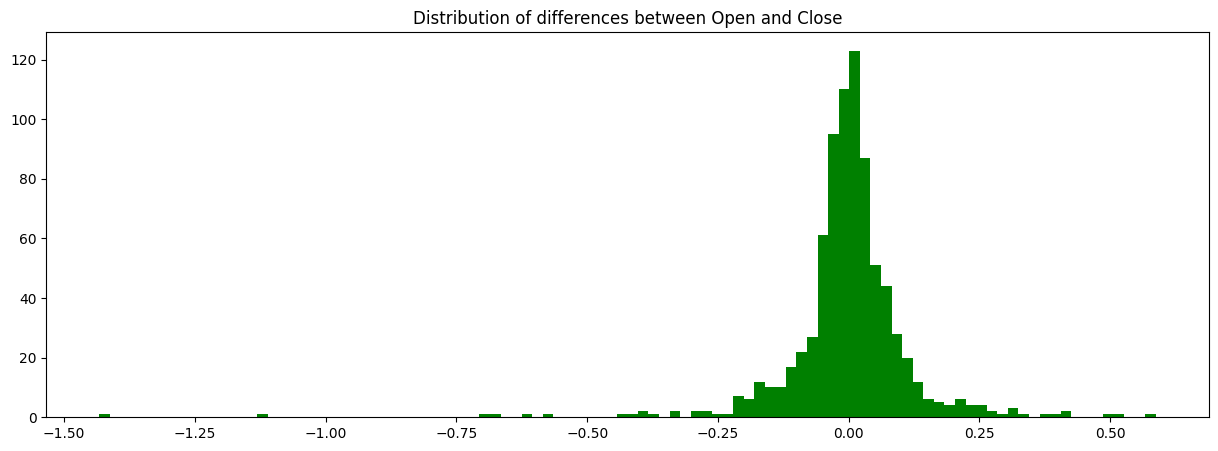

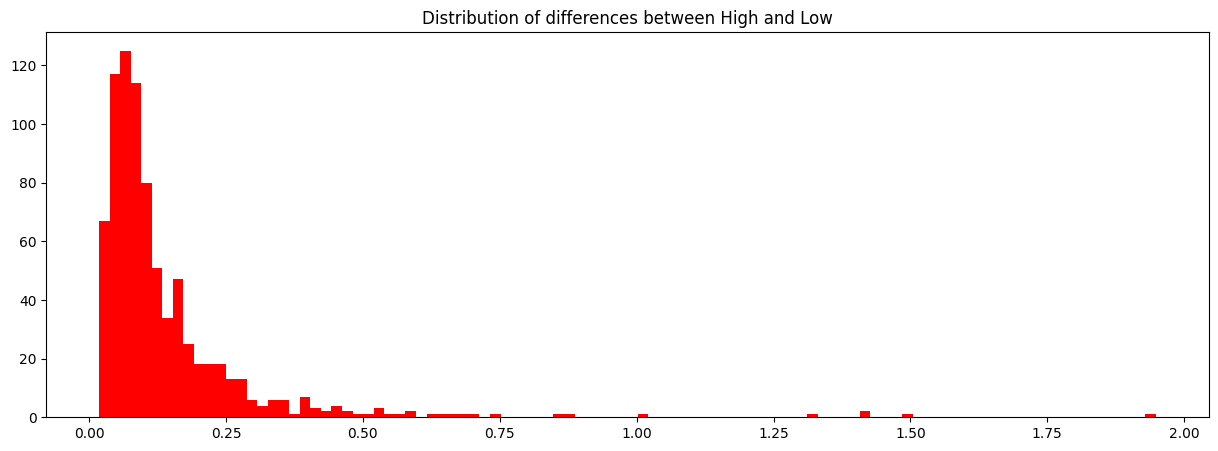

In [33]:
# plot distribution between open and close

df['diff_open_close'] = df['Open'] - df['Close']
df['diff_high_low'] = df['High'] - df['Low']

df['diff_open_close'].hist(bins=100, figsize=(15, 5), grid=False, color='green')
plt.title('Distribution of differences between Open and Close')
plt.show()
df['diff_high_low'].hist(bins=100, figsize=(15, 5), grid=False, color='red')
plt.title('Distribution of differences between High and Low')
plt.show()

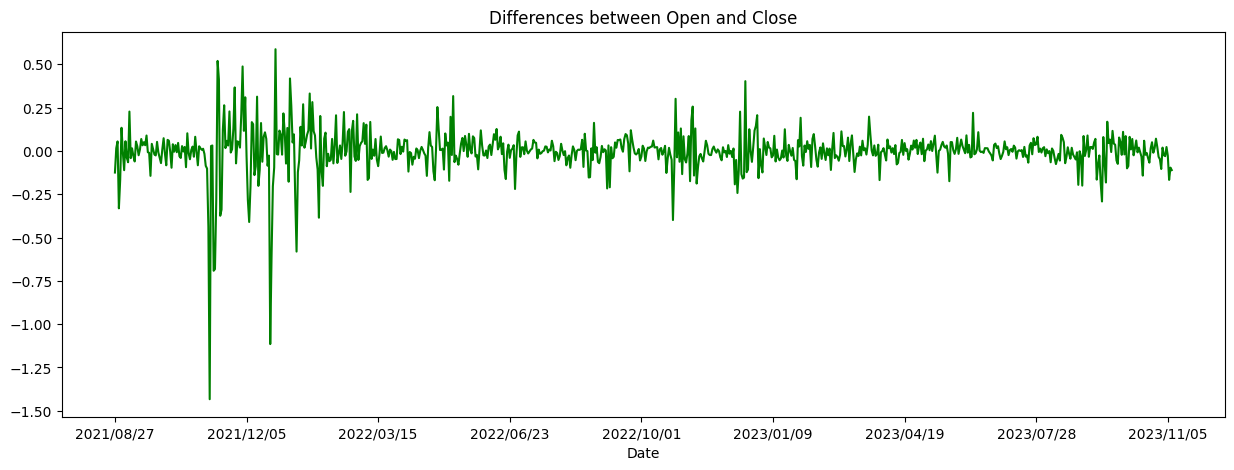

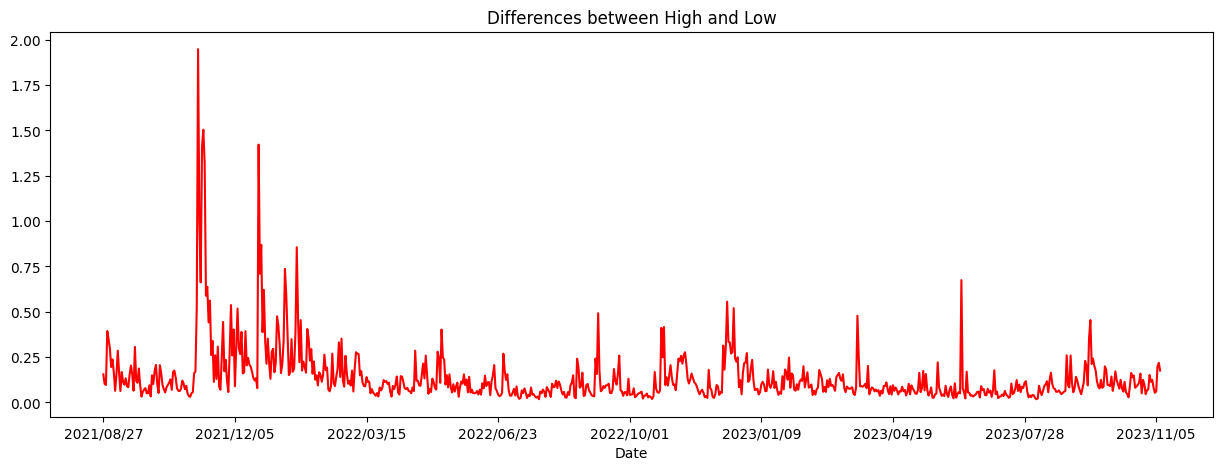

In [34]:
df['diff_open_close'].plot(figsize=(15, 5), grid=False, color='green')
plt.title('Differences between Open and Close')
plt.show()
df['diff_high_low'].plot(figsize=(15, 5), grid=False, color='red')
plt.title('Differences between High and Low')
plt.show()

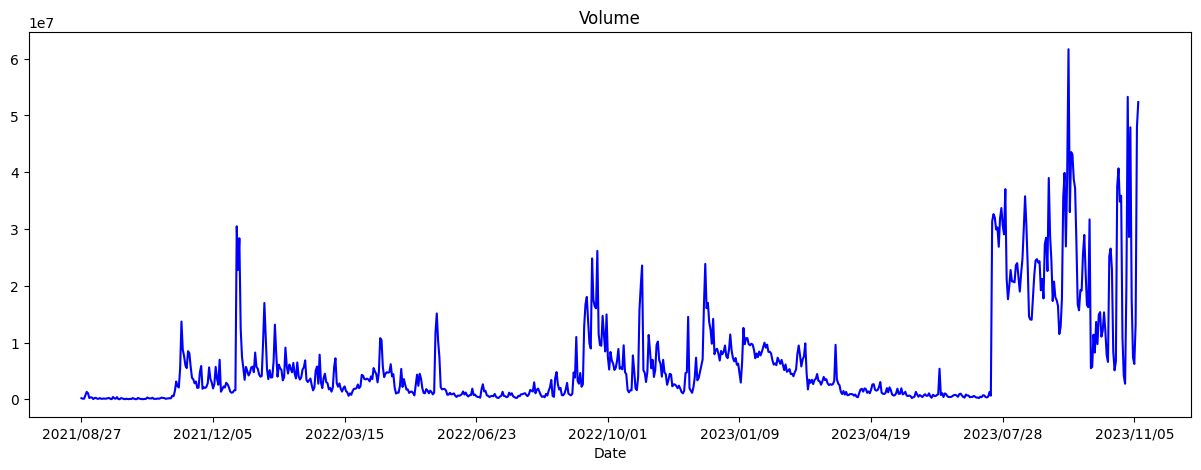

In [35]:
df['Volume'].plot(figsize=(15, 5), grid=False, color='blue')
plt.title('Volume')
plt.show()

To conclude, we will predict close, high and low prices. Because other features have big variance and haven't any trend.

### Data preprocessing, feature engineering and forecasting (draft)

In [61]:
# function to forecast time series
def predict_horizon(model, X, df: pd.DataFrame, column: str,
                    fe_fun: Callable, 
                    horizon: int = 5):
    y_pred = []
    df = df[[column]]
    for i in range(horizon):
        y_pred.append(model.predict(X.iloc[-1:])[0])
        # add new value to df
        next_index = df.index[-1] + pd.DateOffset(days=1)
        df = pd.concat([df, 
                        pd.DataFrame(index=[next_index], columns=df.columns, data=[[y_pred[-1]]])])
        # create new X, y
        X, _ = fe_fun(df)
        
    return y_pred, X

In [58]:
### data preparation

df = df[['Close', 'High', 'Low']]
df.index = pd.to_datetime(df.index)

get_X_y_close = partial(get_X_y_timeseries, column='Close', lags=[1,3], windows_mean=None, dropna=True)
X, y = get_X_y_close(df)

/Users/sudinigor/work/github_repos/coins_forecasting/src/data_preprocessing.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'{column}_lag_{lag}'] = pd.Series(df[column].shift(lag))


Predict with Linear Regression

/Users/sudinigor/work/github_repos/coins_forecasting/src/data_preprocessing.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'{column}_lag_{lag}'] = pd.Series(df[column].shift(lag))


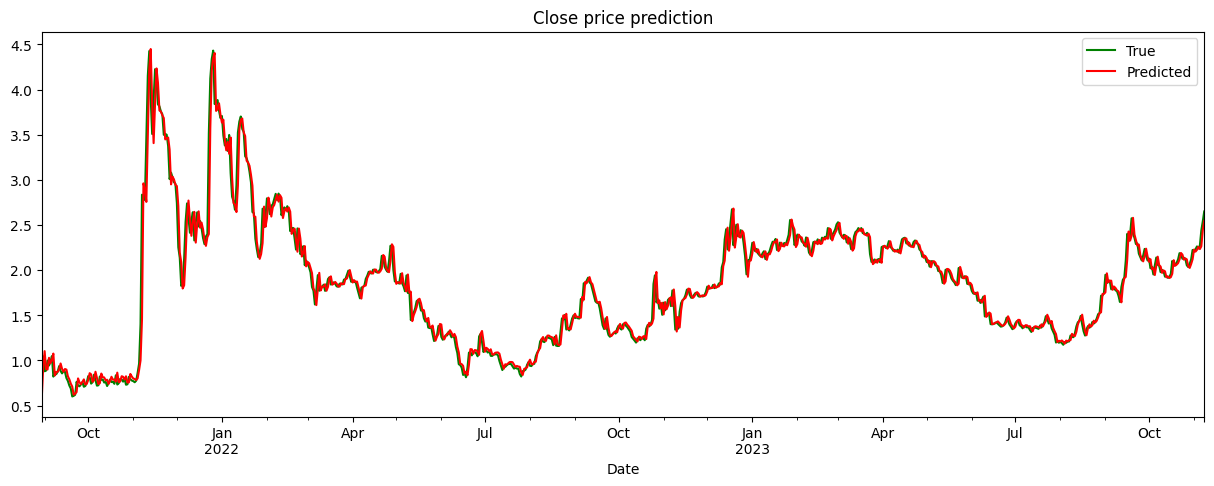

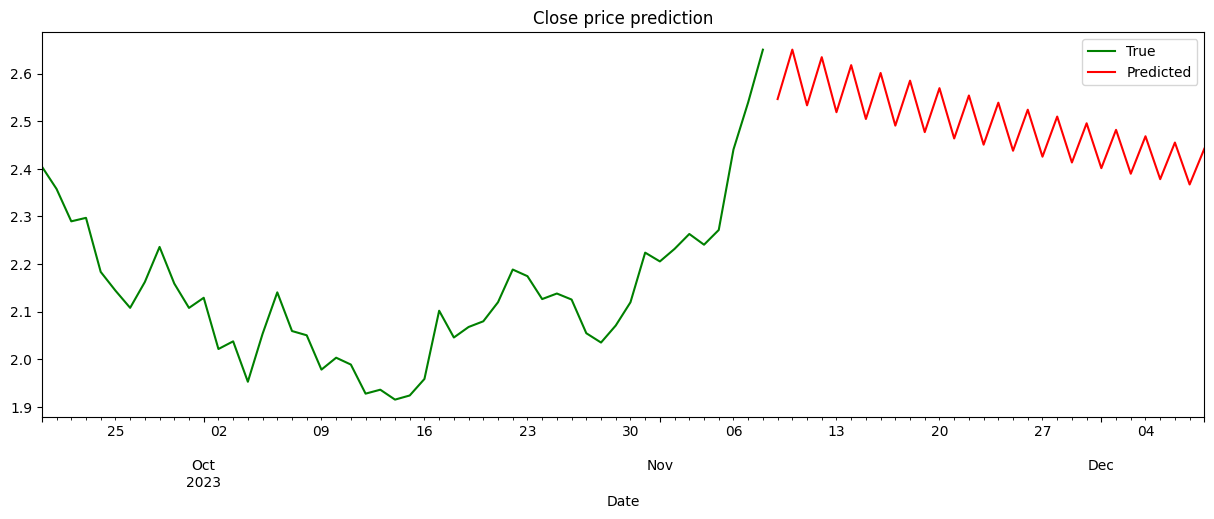

In [69]:
get_X_y_close = partial(get_X_y_timeseries, column='Close', lags=[1, 3], windows_mean=None, dropna=True)
X, y = get_X_y_close(df)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
y_pred = pd.Series(y_pred, index=X.index)


y.plot(figsize=(15, 5), grid=False, color='green')
y_pred.plot(figsize=(15, 5), grid=False, color='red')
plt.legend(['True', 'Predicted'])
plt.title('Close price prediction')
plt.show()

y_pred, X_pred = predict_horizon(model, X, df, 'Close', get_X_y_close, horizon=30)


y_pred = pd.Series(y_pred, index=X_pred.iloc[-len(y_pred):].index)
y[-50:].plot(figsize=(15, 5), grid=False, color='green')
y_pred.plot(figsize=(15, 5), grid=False, color='red')
plt.legend(['True', 'Predicted'])
plt.title('Close price prediction')
plt.show()

/Users/sudinigor/work/github_repos/coins_forecasting/src/data_preprocessing.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df = add_rolling_mean(df, column, windows_mean, dropna)


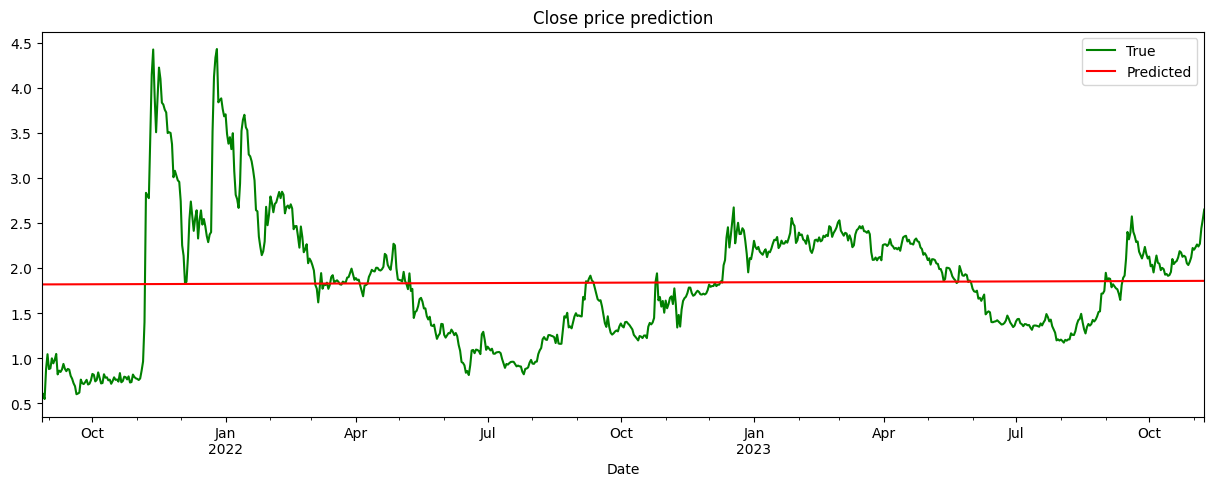

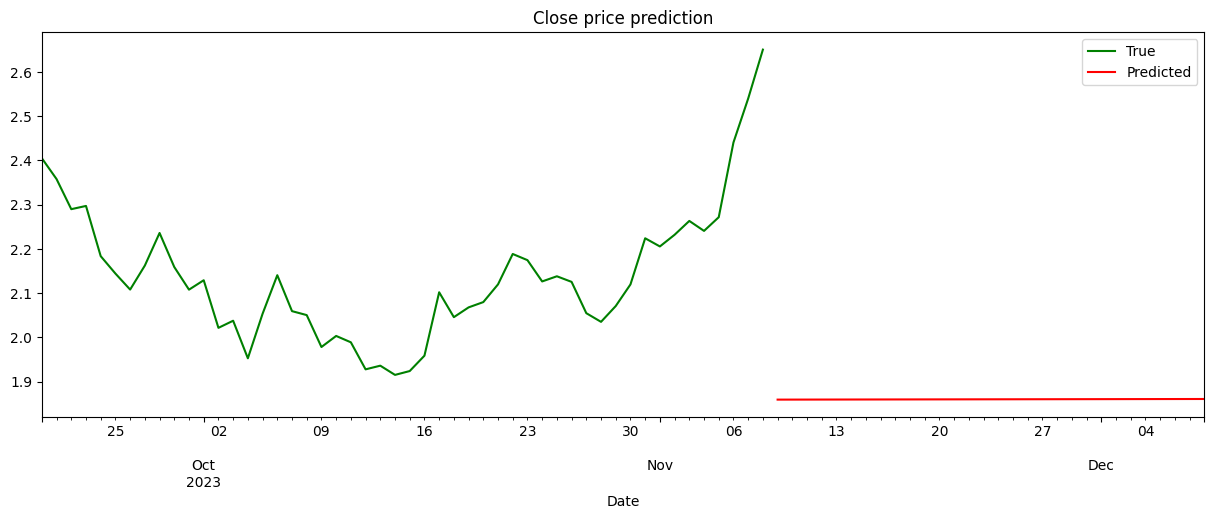

In [71]:
get_X_y_close = partial(get_X_y_timeseries, column='Close', lags=None, windows_mean=None, dropna=True)
X, y = get_X_y_close(df)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
y_pred = pd.Series(y_pred, index=X.index)

y.plot(figsize=(15, 5), grid=False, color='green')
y_pred.plot(figsize=(15, 5), grid=False, color='red')
plt.legend(['True', 'Predicted'])
plt.title('Close price prediction')
plt.show()

y_pred, X_pred = predict_horizon(model, X, df, 'Close', get_X_y_close, horizon=30)

y_pred = pd.Series(y_pred, index=X_pred.iloc[-len(y_pred):].index)
y[-50:].plot(figsize=(15, 5), grid=False, color='green')
y_pred.plot(figsize=(15, 5), grid=False, color='red')
plt.legend(['True', 'Predicted'])
plt.title('Close price prediction')
plt.show()

Linear Regression tends to overfit, so we will use xgboost and LSTM.

In [ ]:
# TODO xgboost and LSTM

/Users/sudinigor/work/github_repos/coins_forecasting/src/data_preprocessing.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f'{column}_lag_{lag}'] = pd.Series(df[column].shift(lag))


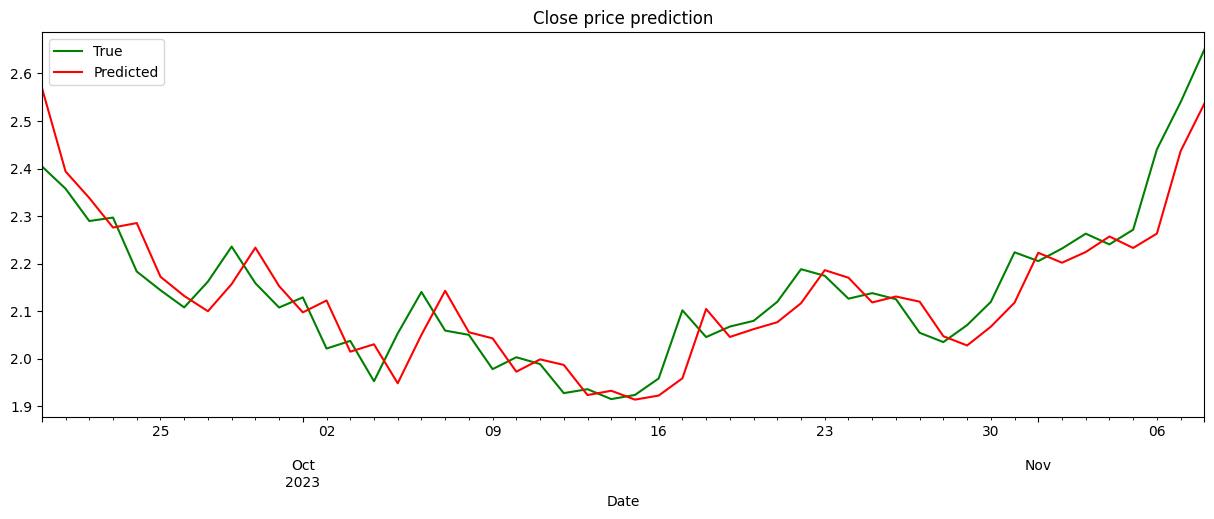

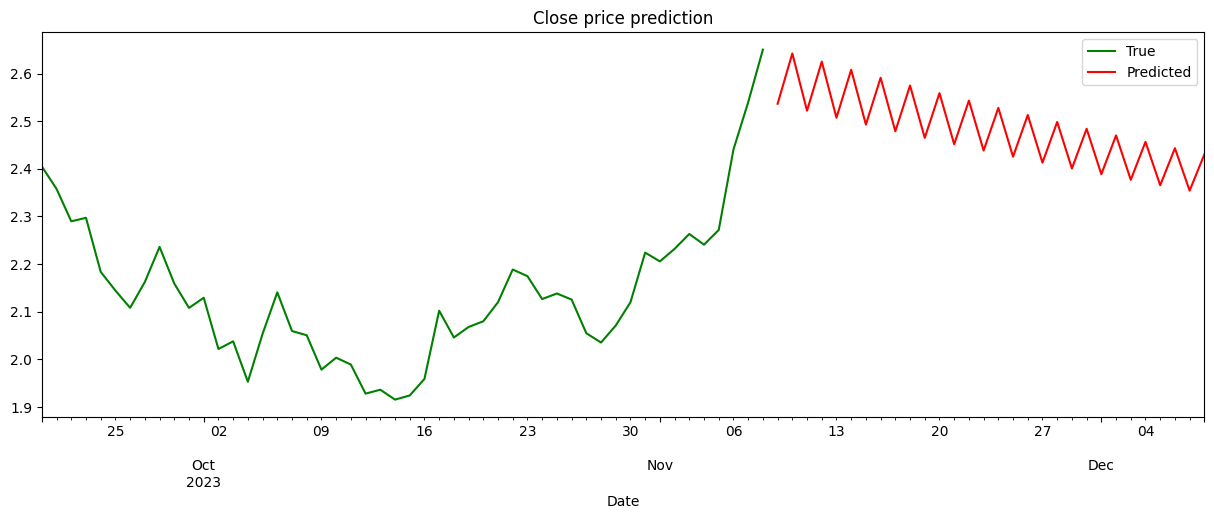

In [74]:
from xgboost import XGBRegressor

get_X_y_close = partial(get_X_y_timeseries, column='Close', lags=[1, 3], windows_mean=None, dropna=True)
X, y = get_X_y_close(df)

model = Ridge()
model.fit(X, y)

y_pred = model.predict(X)
y_pred = pd.Series(y_pred, index=X.index)


y[-50:].plot(figsize=(15, 5), grid=False, color='green')
y_pred[-50:].plot(figsize=(15, 5), grid=False, color='red')
plt.legend(['True', 'Predicted'])
plt.title('Close price prediction')
plt.show()

y_pred, X_pred = predict_horizon(model, X, df, 'Close', get_X_y_close, horizon=30)


y_pred = pd.Series(y_pred, index=X_pred.iloc[-len(y_pred):].index)
y[-50:].plot(figsize=(15, 5), grid=False, color='green')
y_pred.plot(figsize=(15, 5), grid=False, color='red')
plt.legend(['True', 'Predicted'])
plt.title('Close price prediction')
plt.show()


In [43]:
y_pred

2023-11-09    2.575220
2023-11-10    2.557055
2023-11-11    2.603209
2023-11-12    2.588807
2023-11-13    2.572535
2023-11-14    2.587454
2023-11-15    2.587708
2023-11-16    2.579704
2023-11-17    2.583152
2023-11-18    2.584997
2023-11-19    2.581916
2023-11-20    2.582094
2023-11-21    2.583100
2023-11-22    2.582059
2023-11-23    2.581623
2023-11-24    2.581903
2023-11-25    2.581519
2023-11-26    2.581104
2023-11-27    2.581032
2023-11-28    2.580799
2023-11-29    2.580471
2023-11-30    2.580267
2023-12-01    2.580044
2023-12-02    2.579764
2023-12-03    2.579517
2023-12-04    2.579278
2023-12-05    2.579014
2023-12-06    2.578754
2023-12-07    2.578500
2023-12-08    2.578237
dtype: float64

In [44]:
X.iloc[-1:]

,Close_lag_1,Close_rolling_mean_3,Time
Date,,,
2023-11-13,2.56994,2.573727,805


In [45]:
model.predict(X.iloc[-1:])

array([2.57522009])

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster

In [48]:
y

Date
2021-08-30    0.879532
2021-08-31    1.045401
2021-09-01    0.880423
2021-09-02    0.888264
2021-09-03    0.999546
                ...   
2023-11-09    2.544976
2023-11-10    2.541952
2023-11-11    2.595670
2023-11-12    2.569940
2023-11-13    2.555573
Name: Close, Length: 806, dtype: float64

In [49]:
df_t = df.copy(deep=True)

In [50]:
add_rolling_mean(df_t, 'Open', range(1, 10))

KeyError: 'Open'

In [ ]:
df

,Volume,Open,Close,High,Low,diff_open_close,diff_high_low
Date,,,,,,,
2021/08/27,2.045602e+05,0.493377,0.618263,0.619192,0.463996,-0.124886,0.155196
2021/08/28,1.166856e+05,0.618263,0.602768,0.633747,0.531502,0.015495,0.102245
2021/08/29,1.105447e+05,0.602768,0.548015,0.610971,0.514528,0.054753,0.096443
2021/08/30,6.956799e+05,0.548015,0.879532,0.939249,0.545316,-0.331517,0.393933
2021/08/31,1.317655e+06,0.879532,1.045401,1.148265,0.798556,-0.165869,0.349709
...,...,...,...,...,...,...,...
2023/11/04,7.398260e+06,2.262895,2.240535,2.271676,2.218343,0.022360,0.053333
2023/11/05,6.239786e+06,2.243556,2.271499,2.298389,2.237974,-0.027943,0.060415
2023/11/06,1.314340e+07,2.273053,2.440416,2.470703,2.273053,-0.167362,0.197650


### Trainig and testing (draft)